# Packages Loading

In [ ]:
import re
import nltk
import torch
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from collections import defaultdict
from nltk.stem import PorterStemmer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, DistilBertTokenizer, DistilBertForSequenceClassification, XLMRobertaTokenizer, XLMRobertaForSequenceClassification, get_linear_schedule_with_warmup


# Data Mount

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Load data
ds = pd.read_csv('/content/gdrive/MyDrive/mbti_1.csv')

# Display sample posts
print("Sample post from ds:")
print(ds['posts'][2])

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Sample post from ds:
'Good one  _____   https://www.youtube.com/watch?v=fHiGbolFFGw|||Of course, to which I say I know; that's my blessing and my curse.|||Does being absolutely positive that you and your best friend could be an amazing couple count? If so, than yes.   Or it's more I could be madly in love in case I reconciled my feelings (which at...|||No, I didn't; thank you for a link!|||So-called Ti-Si loop (and it can stem from any current topic/obsession) can be deadly. It's like when you're stuck in your own thoughts, and your mind just wanders in circles. Feels truly terrible. ...|||Have you noticed how peculiar vegetation can be? All you have to do is look down at the grass: dozens of different plant species there.    And now imagine that hundreds of years later (when/if soil...|||The Smiths – Never Had No One Ever|||I often find myself spotting fac

# Data Visualization

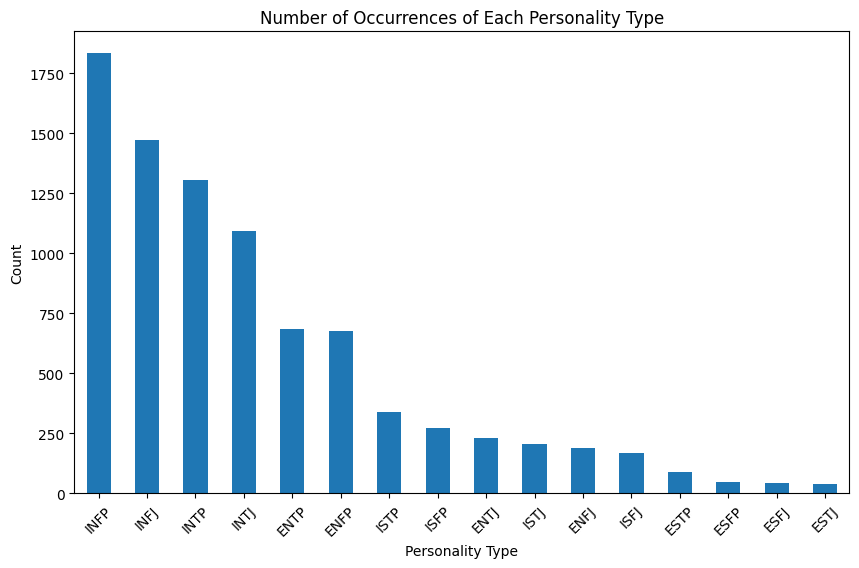

In [ ]:
# Plot distribution of personality types
plt.figure(figsize=(10, 6))
ds["type"].value_counts().plot(kind="bar")
plt.title("Number of Occurrences of Each Personality Type")
plt.xlabel("Personality Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


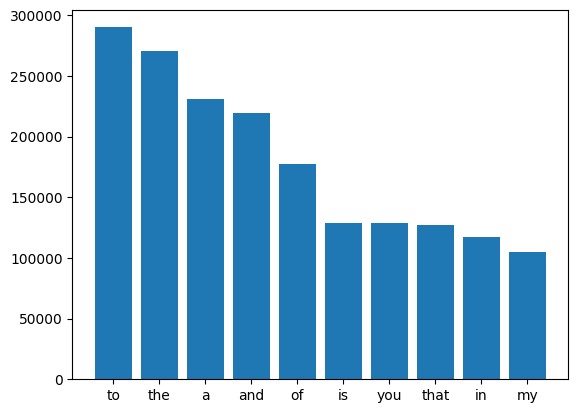

In [ ]:
# Plot top stopwords
nltk.download('stopwords')
def plot_top_stopwords_barchart(text):
   stop = set(stopwords.words('english'))
   new = text.str.split()
   new = new.values.tolist()
   corpus = [word for i in new for word in i]
   dic = defaultdict(int)
   for word in corpus:
       if word in stop:
           dic[word] += 1

   top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]
   x, y = zip(*top)
   plt.bar(x, y)

plot_top_stopwords_barchart(ds['posts'])

# Data Cleaning

In [ ]:
# Data Cleaning
nltk.download("stopwords")
ds["clean posts"] = ds["posts"].str.lower().apply(lambda x: re.sub(r"https?:\/\/(www)?.?([A-Za-z_0-9-]+)([\S])*", "", x)) \
                                            .apply(lambda x: re.sub("\|\|\|", "", x)) \
                                            .apply(lambda x: re.sub("[0-9]", "", x)) \
                                            .apply(lambda x: re.sub("[^a-z]", " ", x)) \
                                            .apply(lambda x: x.split())
types = [t.lower() for t in ds["type"].unique()]
ds["clean posts"] = ds["clean posts"].apply(lambda post: [word for word in post if word not in types])
all_stopwords = stopwords.words("english")
all_stopwords.remove("not")
ds["clean posts"] = ds["clean posts"].apply(lambda post: [word for word in post if word not in all_stopwords])
ps = PorterStemmer()
ds["clean posts"] = ds["clean posts"].apply(lambda row: " ".join([ps.stem(word) for word in row]))
ds.drop(["posts"], inplace=True, axis=1)
ds.to_csv("mbti_cleaned.csv")
ds = ds[ds["clean posts"].notna()]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
ds

,posts,type
0,know intj tool use interaction people excuse a...,INTJ
1,rap music ehh opp yeah know valid well know fa...,INTJ
2,preferably p hd low except wew lad video p min...,INTJ
3,drink like wish could drink red wine give head...,INTJ
4,space program ah bad deal meing freelance max ...,INTJ
...,...,...
106062,stay frustrate world life want take long nap w...,INFP
106063,fizzle around time mention sure mistake thing ...,INFP
106064,schedule modify hey w intp strong wing underst...,INFP
106065,enfj since january busy schedule able spend li...,INFP


# Define Models and Tokenizer

In [ ]:
# Tokenizers
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
xlmr_tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")
distilbert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-multilingual-cased")

# Models
bert_model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=16,  # Number of unique labels
    output_attentions=False,
    output_hidden_states=False
)

xlmr_model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base",
    num_labels=16,
    output_attentions=False,
    output_hidden_states=False
)

distilbert_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-multilingual-cased",
    num_labels=16,
    output_attentions=False,
    output_hidden_states=False
)

models = {
    "mBERT": (bert_model, bert_tokenizer),
    "XLM-R": (xlmr_model, xlmr_tokenizer),
    "DistilBERT": (distilbert_model, distilbert_tokenizer)
}

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
bert_model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
xlmr_model

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768,

In [ ]:
distilbert_model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


# Define Some Functions

In [ ]:
# Function to preprocess text for BERT
def preprocess_text_bert(text, tokenizer, max_len=128):
    tokenized_text = bert_tokenizer.tokenize(text)
    tokenized_text = ["[CLS]"] + tokenized_text + ["[SEP]"]
    input_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
    input_ids = input_ids[:max_len] + [tokenizer.pad_token_id] * (max_len - len(input_ids))
    attention_mask = [1] * len(input_ids)
    return torch.tensor(input_ids), torch.tensor(attention_mask)

# Function to preprocess text for DistilBERT
def preprocess_text_distilbert(text, tokenizer, max_len=128):
    inputs = distilbert_tokenizer(
       text,
       padding='max_length',
       truncation=True,
       max_length=max_len,
       return_tensors='pt'
    )
    return inputs.input_ids, inputs.attention_mask

def preprocess_text_xlmr(text, tokenizer, max_len=128):
    inputs = xlmr_tokenizer(
       text,
       padding='max_length',
       truncation=True,
       max_length=max_len,
       return_tensors='pt'
    )
    return inputs.input_ids, inputs.attention_mask


In [ ]:
# Function to train and evaluate a model
def train_and_evaluate(model, train_dataloader, test_dataloader, optimizer, scheduler, device, epochs=3):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}"):
            batch = tuple(t.to(device) for t in batch)
            inputs, masks, labels = batch
            model.zero_grad()
            outputs = model(inputs, attention_mask=masks, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(train_dataloader)
        print(f"Average Training Loss for {model.__class__.__name__}: {avg_train_loss}")

    model.eval()
    preds = []
    true_labels = []
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        batch = tuple(t.to(device) for t in batch)
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks)
            logits = outputs.logits
        preds.append(logits.detach().cpu().numpy())
        true_labels.append(labels.cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)
    return preds, true_labels

In [ ]:

def plot_confusion_matrix(conf_matrix, label_names, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    plt.title(title)  # Set the title here
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

def calculate_metrics(true_labels, predicted_labels):
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    class_report = classification_report(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    return conf_matrix, class_report, accuracy, f1, precision, recall


In [ ]:
# Function to plot ROC curve and calculate AUC
def plot_roc_curve(true_labels, predicted_probs, label_names):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(label_names)):
        fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predicted_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(true_labels.ravel(), predicted_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=2, label='Micro-average ROC curve (area = %0.2f)' % roc_auc["micro"])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Define Model Dictionary

In [ ]:
# Define labels dictionary
labels_dict = {
    'INFJ': 0, 'ENTP': 1, 'INTP': 2, 'INTJ': 3, 'ENTJ': 4,
    'ENFJ': 5, 'INFP': 6, 'ENFP': 7, 'ISFP': 8, 'ISTP': 9,
    'ISFJ': 10, 'ISTJ': 11, 'ESTP': 12, 'ESFP': 13,
    'ESTJ': 14, 'ESFJ': 15
}

# Model Fine Tuning

In [ ]:
# Define batch size and other parameters
batch_size = 32
max_len = 128
epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
input_ids_list = []
attention_mask_list = []

input_ids_list_xlmr = []
attention_mask_list_xlmr = []

input_ids_list_distilbert = []
attention_mask_list_distilbert = []

labels = [labels_dict[label] for label in ds['type']]
labels = torch.tensor(labels)

for text in ds['clean posts']:
    # For mBERT
    input_ids, attention_mask = preprocess_text_bert(text, models['mBERT'][1], max_len)
    input_ids_list.append(input_ids)
    attention_mask_list.append(attention_mask)

    # For XLM-R
    input_ids_xlmr, attention_mask_xlmr = preprocess_text_xlmr(text, models['XLM-R'][1], max_len)
    input_ids_list_xlmr.append(input_ids_xlmr)
    attention_mask_list_xlmr.append(attention_mask_xlmr)

    # For DistilBERT
    input_ids_distilbert, attention_mask_distilbert = preprocess_text_distilbert(text, models['DistilBERT'][1], max_len)
    input_ids_list_distilbert.append(input_ids_distilbert)
    attention_mask_list_distilbert.append(attention_mask_distilbert)


input_ids_tensor_bert = torch.stack(input_ids_list)
attention_mask_tensor_bert = torch.stack(attention_mask_list)

input_ids_tensor_xlmr = torch.stack(input_ids_list_xlmr)
attention_mask_tensor_xlmr = torch.stack(attention_mask_list_xlmr)

input_ids_tensor_distilbert = torch.stack(input_ids_list_distilbert)
attention_mask_tensor_distilbert = torch.stack(attention_mask_list_distilbert)


In [ ]:
# For BERT

train_inputs_bert, test_inputs_bert, train_masks_bert, test_masks_bert, train_labels_bert, test_labels_bert = train_test_split(
    input_ids_tensor_bert, attention_mask_tensor_bert, labels, test_size=0.3, random_state=42
)

train_data_bert = TensorDataset(train_inputs_bert, train_masks_bert, train_labels_bert)
train_sampler_bert = RandomSampler(train_data_bert)
train_dataloader_bert = DataLoader(train_data_bert, sampler=train_sampler_bert, batch_size=batch_size)

test_data_bert = TensorDataset(test_inputs_bert, test_masks_bert, test_labels_bert)
test_sampler_bert = SequentialSampler(test_data_bert)
test_dataloader_bert = DataLoader(test_data_bert, sampler=test_sampler_bert, batch_size=batch_size)



# For XLM-R
train_inputs_xlmr, test_inputs_xlmr, train_masks_xlmr, test_masks_xlmr, train_labels_xlmr, test_labels_xlmr = train_test_split(
    input_ids_tensor_xlmr, attention_mask_tensor_xlmr, labels, test_size=0.3, random_state=42
)

train_data_xlmr = TensorDataset(train_inputs_xlmr, train_masks_xlmr, train_labels_xlmr)
train_sampler_xlmr = RandomSampler(train_data_xlmr)
train_dataloader_xlmr = DataLoader(train_data_xlmr, sampler=train_sampler_xlmr, batch_size=batch_size)

test_data_xlmr = TensorDataset(test_inputs_xlmr, test_masks_xlmr, test_labels_xlmr)
test_sampler_xlmr = SequentialSampler(test_data_xlmr)
test_dataloader_xlmr = DataLoader(test_data_xlmr, sampler=test_sampler_xlmr, batch_size=batch_size)

# For DistilBERT
train_inputs_distilbert, test_inputs_distilbert, train_masks_distilbert, test_masks_distilbert, train_labels_distilbert, test_labels_distilbert = train_test_split(
    input_ids_tensor_distilbert, attention_mask_tensor_distilbert, labels, test_size=0.3, random_state=42
)

train_data_distilbert = TensorDataset(train_inputs_distilbert, train_masks_distilbert, train_labels_distilbert)
train_sampler_distilbert = RandomSampler(train_data_distilbert)
train_dataloader_distilbert = DataLoader(train_data_distilbert, sampler=train_sampler_distilbert, batch_size=batch_size)

test_data_distilbert = TensorDataset(test_inputs_distilbert, test_masks_distilbert, test_labels_distilbert)
test_sampler_distilbert = SequentialSampler(test_data_distilbert)
test_dataloader_distilbert = DataLoader(test_data_distilbert, sampler=test_sampler_distilbert, batch_size=batch_size)




# Define a dictionary to store train data loaders for each model
train_dataloaders_dict = {
    "mBERT": train_dataloader_bert,
    "XLM-R": train_dataloader_xlmr,
    "DistilBERT": train_dataloader_distilbert
}


# Define a dictionary to store train data loaders for each model
test_dataloaders_dict = {
    "mBERT": test_dataloader_bert,
    "XLM-R": test_dataloader_xlmr,
    "DistilBERT": test_dataloader_distilbert
}



In [ ]:
results = {}

# Training and evaluation loop for all models
for model_name, (model, tokenizer) in models.items():
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
    total_steps = len(train_dataloaders_dict[model_name]) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    print(f"Training {model_name}...")

    # Move model to device
    model.to(device)

    if model_name == 'XLM-R' or model_name == 'DistilBERT' or model_name == 'mBERT':
        for epoch in range(epochs):
            model.train()
            total_loss = 0
            for batch in tqdm(train_dataloaders_dict[model_name], desc=f"Epoch {epoch + 1}"):
                batch = tuple(t.to(device) for t in batch)
                inputs, masks, labels = batch

                inputs = inputs.squeeze(1)  # Remove the extra dimension
                masks = masks.squeeze(1)  # Remove the extra dimension

                model.zero_grad()
                outputs = model(inputs, attention_mask=masks, labels=labels)
                loss = outputs.loss
                total_loss += loss.item()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()

            avg_train_loss = total_loss / len(train_dataloaders_dict[model_name])
            print(f"Average Training Loss for {model_name}: {avg_train_loss}")

    # Evaluation loop for BERT
    if model_name == 'mBERT':
        model.eval()
        preds_bert = []
        for batch in tqdm(test_dataloader_bert, desc="Evaluating BERT"):
            batch = tuple(t.to(device) for t in batch)
            inputs, masks, labels = batch
            with torch.no_grad():
                outputs = model(inputs, attention_mask=masks)
                logits = outputs.logits
            logits = logits.detach().cpu().numpy()
            preds_bert.append(logits)
        preds_bert = np.concatenate(preds_bert, axis=0)
        results[model_name] = preds_bert

    # Evaluation loop for DistilBERT
    elif model_name == 'DistilBERT':
        model.eval()
        preds_distilbert = []
        for batch in tqdm(test_dataloader_distilbert, desc="Evaluating DistilBERT"):
            batch = tuple(t.to(device) for t in batch)
            inputs, masks, labels = batch

            # Ensure correct shape of inputs and masks
            inputs = inputs.squeeze(1)  # Remove the extra dimension
            masks = masks.squeeze(1)  # Remove the extra dimension

            with torch.no_grad():
                outputs = model(inputs, attention_mask=masks)
                logits = outputs.logits
            logits = logits.detach().cpu().numpy()
            preds_distilbert.append(logits)
        preds_distilbert = np.concatenate(preds_distilbert, axis=0)
        results[model_name] = preds_distilbert

    # Evaluation loop for XLM-R
    elif model_name == 'XLM-R':
        model.eval()
        preds_xlmr = []
        for batch in tqdm(test_dataloader_xlmr, desc="Evaluating XLM-R"):
            batch = tuple(t.to(device) for t in batch)
            inputs, masks, labels = batch

            # Ensure correct shape of inputs and masks
            inputs = inputs.squeeze(1)  # Remove the extra dimension
            masks = masks.squeeze(1)  # Remove the extra dimension

            with torch.no_grad():
                outputs = model(inputs, attention_mask=masks)
                logits = outputs.logits
            logits = logits.detach().cpu().numpy()
            preds_xlmr.append(logits)
        preds_xlmr = np.concatenate(preds_xlmr, axis=0)
        results[model_name] = preds_xlmr


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training mBERT...


Epoch 1: 100%|██████████| 190/190 [02:07<00:00,  1.48it/s]


Average Training Loss for mBERT: 2.310047205498344


Epoch 2: 100%|██████████| 190/190 [02:16<00:00,  1.40it/s]


Average Training Loss for mBERT: 2.224282493716792


Epoch 3: 100%|██████████| 190/190 [02:16<00:00,  1.39it/s]


Average Training Loss for mBERT: 2.1482100110304985


Evaluating BERT: 100%|██████████| 82/82 [00:18<00:00,  4.40it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training XLM-R...


Epoch 1: 100%|██████████| 190/190 [02:23<00:00,  1.32it/s]


Average Training Loss for XLM-R: 2.3358777673620925


Epoch 2: 100%|██████████| 190/190 [02:23<00:00,  1.33it/s]


Average Training Loss for XLM-R: 2.2918037345534876


Epoch 3: 100%|██████████| 190/190 [02:23<00:00,  1.33it/s]


Average Training Loss for XLM-R: 2.245168499570144


Evaluating XLM-R: 100%|██████████| 82/82 [00:18<00:00,  4.41it/s]


Training DistilBERT...


Epoch 1: 100%|██████████| 190/190 [01:09<00:00,  2.74it/s]


Average Training Loss for DistilBERT: 2.3394418139206734


Epoch 2: 100%|██████████| 190/190 [01:09<00:00,  2.72it/s]


Average Training Loss for DistilBERT: 2.252361301999343


Epoch 3: 100%|██████████| 190/190 [01:09<00:00,  2.73it/s]


Average Training Loss for DistilBERT: 2.2077916622161866


Evaluating DistilBERT: 100%|██████████| 82/82 [00:09<00:00,  8.60it/s]


# ROC Curve

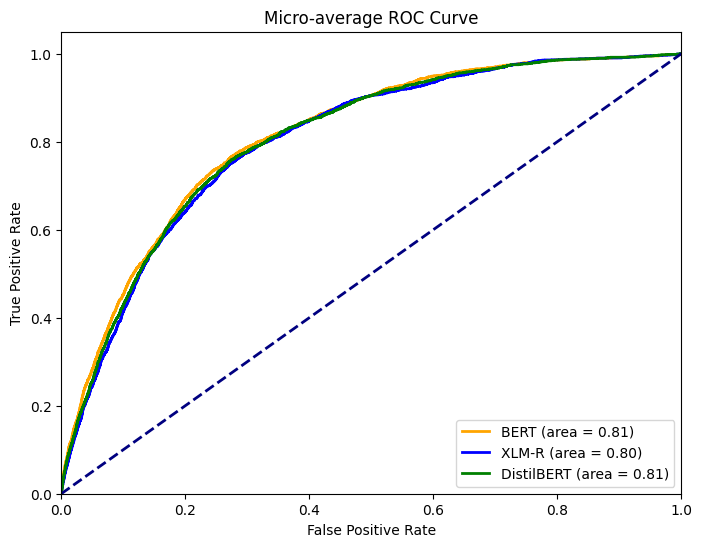

In [ ]:
# Convert labels to one-hot encoded format for BERT
one_hot_labels_bert = np.zeros((len(test_labels_bert), len(labels_dict)))
for i, label in enumerate(test_labels_bert):
    one_hot_labels_bert[i, label] = 1

# Compute probabilities for each class for BERT
probabilities_bert = np.exp(preds_bert) / np.exp(preds_bert).sum(axis=1, keepdims=True)

# Compute ROC curve and AUC score for each class for BERT
fpr_bert = dict()
tpr_bert = dict()
roc_auc_bert = dict()
for i in range(len(labels_dict)):
    fpr_bert[i], tpr_bert[i], _ = roc_curve(one_hot_labels_bert[:, i], probabilities_bert[:, i])
    roc_auc_bert[i] = auc(fpr_bert[i], tpr_bert[i])

# Compute micro-average ROC curve and AUC score for BERT
fpr_bert["micro"], tpr_bert["micro"], _ = roc_curve(one_hot_labels_bert.ravel(), probabilities_bert.ravel())
roc_auc_bert["micro"] = auc(fpr_bert["micro"], tpr_bert["micro"])

# Convert labels to one-hot encoded format for XLM-R
one_hot_labels_xlmr = np.zeros((len(test_labels_xlmr), len(labels_dict)))
for i, label in enumerate(test_labels_xlmr):
    one_hot_labels_xlmr[i, label] = 1

# Compute probabilities for each class for XLM-R
probabilities_xlmr = np.exp(preds_xlmr) / np.exp(preds_xlmr).sum(axis=1, keepdims=True)

# Compute ROC curve and AUC score for each class for XLM-R
fpr_xlmr = dict()
tpr_xlmr = dict()
roc_auc_xlmr = dict()
for i in range(len(labels_dict)):
    fpr_xlmr[i], tpr_xlmr[i], _ = roc_curve(one_hot_labels_xlmr[:, i], probabilities_xlmr[:, i])
    roc_auc_xlmr[i] = auc(fpr_xlmr[i], tpr_xlmr[i])

# Compute micro-average ROC curve and AUC score for XLM-R
fpr_xlmr["micro"], tpr_xlmr["micro"], _ = roc_curve(one_hot_labels_xlmr.ravel(), probabilities_xlmr.ravel())
roc_auc_xlmr["micro"] = auc(fpr_xlmr["micro"], tpr_xlmr["micro"])

# Convert labels to one-hot encoded format for DistilBERT
one_hot_labels_distilbert = np.zeros((len(test_labels_distilbert), len(labels_dict)))
for i, label in enumerate(test_labels_distilbert):
    one_hot_labels_distilbert[i, label] = 1

# Compute probabilities for each class for DistilBERT
probabilities_distilbert = np.exp(preds_distilbert) / np.exp(preds_distilbert).sum(axis=1, keepdims=True)

# Compute ROC curve and AUC score for each class for DistilBERT
fpr_distilbert = dict()
tpr_distilbert = dict()
roc_auc_distilbert = dict()
for i in range(len(labels_dict)):
    fpr_distilbert[i], tpr_distilbert[i], _ = roc_curve(one_hot_labels_distilbert[:, i], probabilities_distilbert[:, i])
    roc_auc_distilbert[i] = auc(fpr_distilbert[i], tpr_distilbert[i])

# Compute micro-average ROC curve and AUC score for DistilBERT
fpr_distilbert["micro"], tpr_distilbert["micro"], _ = roc_curve(one_hot_labels_distilbert.ravel(), probabilities_distilbert.ravel())
roc_auc_distilbert["micro"] = auc(fpr_distilbert["micro"], tpr_distilbert["micro"])

# Plot micro-average ROC curve for all models
plt.figure(figsize=(8, 6))
plt.plot(fpr_bert["micro"], tpr_bert["micro"], color='orange', lw=2, label=f'BERT (area = {roc_auc_bert["micro"]:.2f})')
plt.plot(fpr_xlmr["micro"], tpr_xlmr["micro"], color='blue', lw=2, label=f'XLM-R (area = {roc_auc_xlmr["micro"]:.2f})')
plt.plot(fpr_distilbert["micro"], tpr_distilbert["micro"], color='green', lw=2, label=f'DistilBERT (area = {roc_auc_distilbert["micro"]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve')
plt.legend(loc="lower right")
plt.show()


# Classification Report

In [ ]:
# Convert predicted labels to the original label format
pred_labels_bert = np.argmax(probabilities_bert, axis=1)
pred_labels_xlmr = np.argmax(probabilities_xlmr, axis=1)
pred_labels_distilbert = np.argmax(probabilities_distilbert, axis=1)

# Compute classification report, accuracy, precision, recall, and F1 score for BERT
class_report_bert = classification_report(test_labels_bert, pred_labels_bert)
accuracy_bert = accuracy_score(test_labels_bert, pred_labels_bert)
precision_bert = precision_score(test_labels_bert, pred_labels_bert, average='weighted')
recall_bert = recall_score(test_labels_bert, pred_labels_bert, average='weighted')
f1_bert = f1_score(test_labels_bert, pred_labels_bert, average='weighted')

# Compute classification report, accuracy, precision, recall, and F1 score for XLM-R
class_report_xlmr = classification_report(test_labels_xlmr, pred_labels_xlmr)
accuracy_xlmr = accuracy_score(test_labels_xlmr, pred_labels_xlmr)
precision_xlmr = precision_score(test_labels_xlmr, pred_labels_xlmr, average='weighted')
recall_xlmr = recall_score(test_labels_xlmr, pred_labels_xlmr, average='weighted')
f1_xlmr = f1_score(test_labels_xlmr, pred_labels_xlmr, average='weighted')

# Compute classification report, accuracy, precision, recall, and F1 score for DistilBERT
class_report_distilbert = classification_report(test_labels_distilbert, pred_labels_distilbert)
accuracy_distilbert = accuracy_score(test_labels_distilbert, pred_labels_distilbert)
precision_distilbert = precision_score(test_labels_distilbert, pred_labels_distilbert, average='weighted')
recall_distilbert = recall_score(test_labels_distilbert, pred_labels_distilbert, average='weighted')
f1_distilbert = f1_score(test_labels_distilbert, pred_labels_distilbert, average='weighted')

# Print classification reports
print("Classification Report for BERT:")
print(class_report_bert)
print(f"Accuracy for BERT: {accuracy_bert}")
print(f"Precision for BERT: {precision_bert}")
print(f"Recall for BERT: {recall_bert}")
print(f"F1 Score for BERT: {f1_bert}")
print()

print("Classification Report for XLM-R:")
print(class_report_xlmr)
print(f"Accuracy for XLM-R: {accuracy_xlmr}")
print(f"Precision for XLM-R: {precision_xlmr}")
print(f"Recall for XLM-R: {recall_xlmr}")
print(f"F1 Score for XLM-R: {f1_xlmr}")
print()

print("Classification Report for DistilBERT:")
print(class_report_distilbert)
print(f"Accuracy for DistilBERT: {accuracy_distilbert}")
print(f"Precision for DistilBERT: {precision_distilbert}")
print(f"Recall for DistilBERT: {recall_distilbert}")
print(f"F1 Score for DistilBERT: {f1_distilbert}")


Classification Report for BERT:
              precision    recall  f1-score   support

           0       0.22      0.11      0.15       434
           1       0.00      0.00      0.00       201
           2       0.23      0.29      0.26       404
           3       0.20      0.37      0.26       311
           4       0.00      0.00      0.00        58
           5       0.00      0.00      0.00        56
           6       0.30      0.68      0.42       566
           7       0.00      0.00      0.00       196
           8       0.00      0.00      0.00        84
           9       0.00      0.00      0.00       101
          10       0.00      0.00      0.00        61
          11       0.00      0.00      0.00        70
          12       0.00      0.00      0.00        25
          13       0.00      0.00      0.00         9
          14       0.00      0.00      0.00        17
          15       0.00      0.00      0.00        10

    accuracy                           0.26     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

# Confusion Matrix

In [ ]:
# Compute confusion matrix for BERT
conf_matrix_bert = confusion_matrix(test_labels_bert, pred_labels_bert)

# Compute confusion matrix for XLM-R
conf_matrix_xlmr = confusion_matrix(test_labels_xlmr, pred_labels_xlmr)

# Compute confusion matrix for DistilBERT
conf_matrix_distilbert = confusion_matrix(test_labels_distilbert, pred_labels_distilbert)

# Define label names based on labels dictionary
label_names = sorted(labels_dict, key=labels_dict.get)


<Figure size 800x600 with 0 Axes>

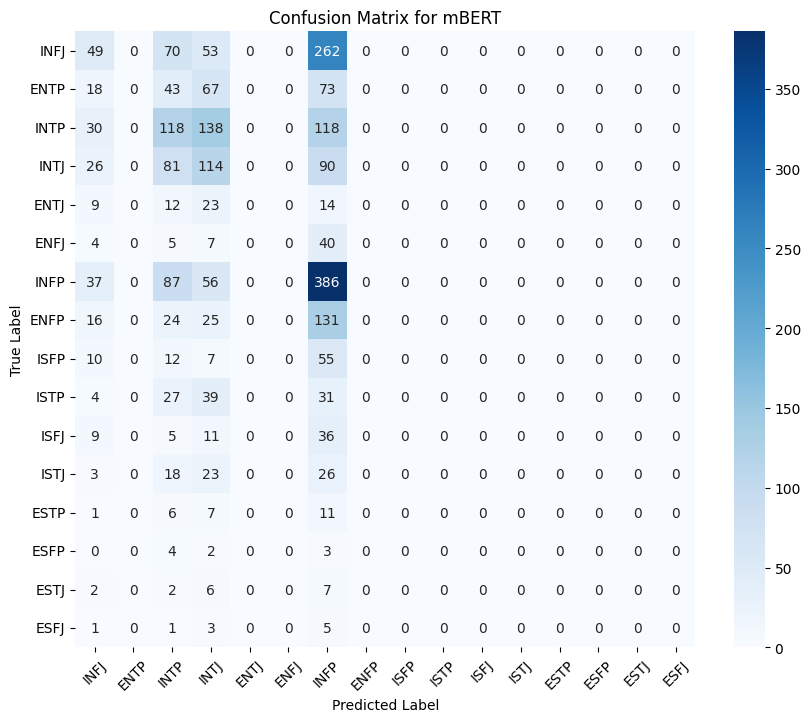

<Figure size 800x600 with 0 Axes>

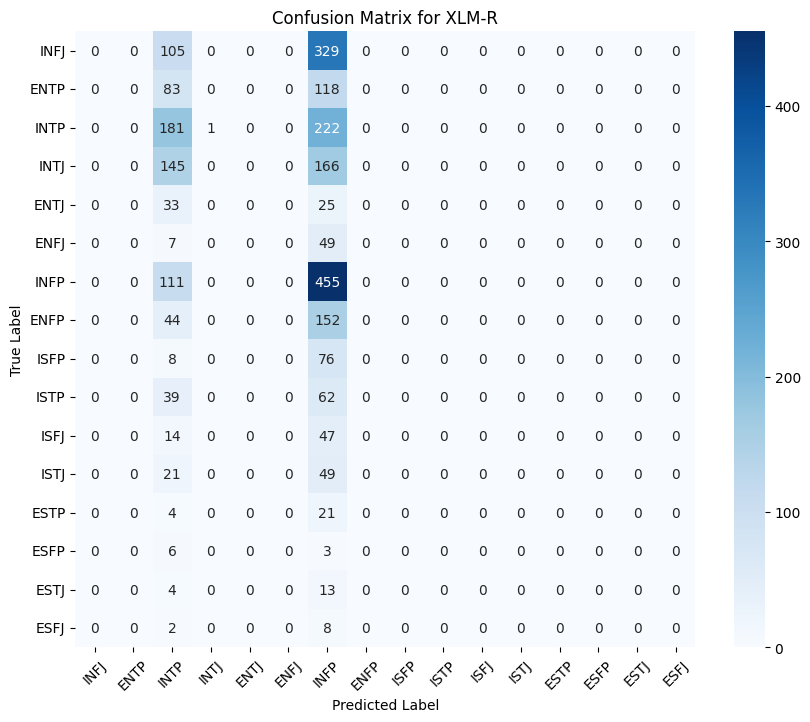

<Figure size 800x600 with 0 Axes>

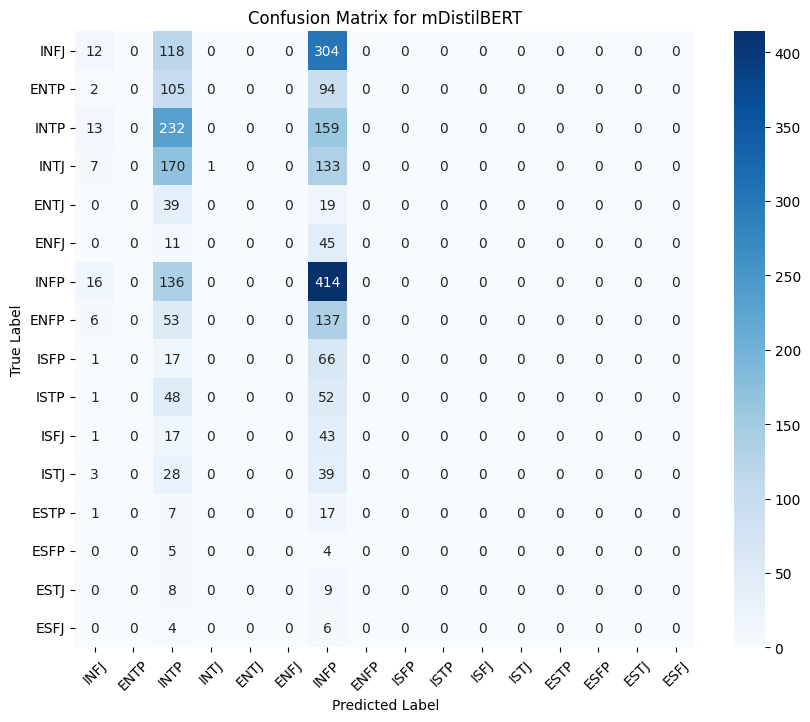

In [ ]:
# Plot confusion matrix for BERT
plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_matrix_bert, label_names, 'Confusion Matrix for mBERT')

# Plot confusion matrix for XLM-R
plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_matrix_xlmr, label_names, 'Confusion Matrix for XLM-R')

# Plot confusion matrix for DistilBERT
plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_matrix_distilbert, label_names, 'Confusion Matrix for mDistilBERT')

# Save the Best Performing Model

In [ ]:
import pickle

# Define the path where you want to save the model
model_save_path = '/content/gdrive/MyDrive/models/final_bert_model.pkl'

# Save the model using pickle
with open(model_save_path, 'wb') as f:
    pickle.dump(bert_model, f)


# Cyber Bullys' Personality Prediction


In [ ]:
import pandas as pd

# Read the CSV file into a DataFrame
cb = pd.read_csv('/content/gdrive/MyDrive/cyberbullying_tweets.csv')

<Axes: xlabel='cyberbullying_type'>

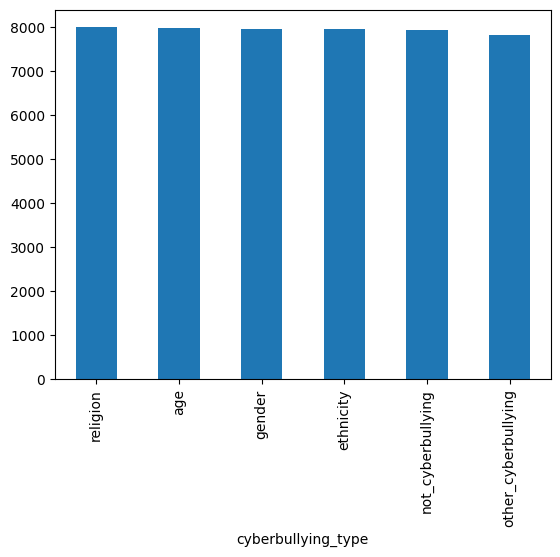

In [ ]:
# Plot the count of each cyberbullying type
cb["cyberbullying_type"].value_counts().plot(kind="bar")

In [ ]:
# Truncate cyberbullying types to 30 characters
cb['cyberbullying_type'] = cb['cyberbullying_type'].str[:30]

In [ ]:
# Create a dictionary to store DataFrames categorized by the first 10 characters
dfs = {}

In [ ]:
# Iterate over unique categories and store filtered DataFrames
for cyberbullying_type in cb['cyberbullying_type'].unique():
    category_cb = cb[cb['cyberbullying_type'] == cyberbullying_type].drop(columns=['cyberbullying_type'])
    dfs[cyberbullying_type] = category_cb

In [ ]:
# Store the segregated DataFrames in a dictionary
segregated_cbs = {
    'not_cyberbul': cb[cb['cyberbullying_type'] == 'not_cyberbul'],
    'gender': cb[cb['cyberbullying_type'] == 'gender'],
    'religion': cb[cb['cyberbullying_type'] == 'religion'],
    'other_cyberb': cb[cb['cyberbullying_type'] == 'not_cyberbul'],
    'age': cb[cb['cyberbullying_type'] == 'age'],
    'ethnicity': cb[cb['cyberbullying_type'] == 'ethnicity']
}

In [ ]:
# Access the segregated DataFrames using their respective category names
not_cyberbul_cb = segregated_cbs['not_cyberbul']
gender_cb = segregated_cbs['gender']
religion_cb = segregated_cbs['religion']
other_cyberb_cb = segregated_cbs['other_cyberb']
age_cb = segregated_cbs['age']
ethnicity_cb = segregated_cbs['ethnicity']

In [ ]:
gender_cb

,tweet_text,cyberbullying_type
7945,rape is real..zvasiyana nema jokes about being...,gender
7946,You never saw any celebrity say anything like ...,gender
7947,"@ManhattaKnight I mean he's gay, but he uses g...",gender
7948,RT @Raul_Novoa16: @AliciaBernardez @Alex_Aim @...,gender
7949,Rape is rape. And the fact that I read one pos...,gender
...,...,...
15913,Any females that really know me know Ion even ...,gender
15914,RT @_chrisdowns_: #QuestionsForMen This one's ...,gender
15915,Sucks to have the smile wiped off your own fac...,gender
15916,"No. He said women choose to be gay, men don't....",gender


In [ ]:
# Initialize Porter Stemmer
ps = PorterStemmer()

# Load the pre-trained BERT model
with open('/content/gdrive/MyDrive/models/final_bert_model.pkl', 'rb') as f:
    bert_model = pickle.load(f)

In [ ]:
# Define function for tweet preprocessing
def preprocess_tweets(tweets):
    corpus = []
    for tweet in tweets:
        # Remove non-alphabetic characters and convert to lowercase
        tweet_text = re.sub("[^a-zA-Z]", " ", tweet)
        tweet_text = tweet_text.lower()

        # Tokenize the tweet
        tweet_text = tweet_text.split()

        # Remove stopwords and apply stemming
        tweet_text = [ps.stem(word) for word in tweet_text if word not in stopwords.words("english")]

        # Join the processed words back into a single string
        tweet_text = " ".join(tweet_text)

        # Append the processed tweet to the corpus
        corpus.append(tweet_text)
    return corpus

In [ ]:
# Define function for BERT prediction
def predict_labels(tokenized_texts):
    predicted_labels = []
    for i in tqdm(range(0, len(tokenized_texts), batch_size), desc="Predicting"):
        input_batch = torch.tensor(tokenized_texts[i:i+batch_size]).to(device)
        with torch.no_grad():
            outputs = bert_model(input_batch)
            logits = outputs.logits

        # Convert logits to probabilities
        probabilities = torch.softmax(logits, dim=1)

        # Get the predicted class index for each sample in the batch
        batch_predicted_class_indices = torch.argmax(probabilities, dim=1).cpu().numpy()

        # Convert the class indices back to their original labels
        batch_predicted_labels = [reverse_class_labels.get(idx, "Unknown") for idx in batch_predicted_class_indices]

        predicted_labels.extend(batch_predicted_labels)
    return predicted_labels

# Define function to process and predict labels for a given category DataFrame
def process_and_predict(df, category_name, reverse_class_labels):
    # Preprocess tweets
    df["tweet_text"] = df["tweet_text"].fillna("")
    corpus = preprocess_tweets(df["tweet_text"])

    # Tokenize the cleaned texts
    tokenized_texts = [tokenizer.encode(text, add_special_tokens=True) for text in corpus]

    # Pad sequences to ensure uniform length
    max_len = max(len(tokens) for tokens in tokenized_texts)
    padded_texts = [tokens + [0] * (max_len - len(tokens)) for tokens in tokenized_texts]

    # Predict labels
    predicted_labels = predict_labels(padded_texts, reverse_class_labels)

    # Create a new DataFrame to store the original data along with the predicted labels
    predicted_df = df.copy()
    predicted_df['predicted_labels'] = predicted_labels[:len(df)]

    # Print the unique predicted labels
    unique_labels = predicted_df['predicted_labels'].unique()
    print(f"Unique labels for '{category_name}': {unique_labels}")

    # Count the occurrences of each label
    label_counts = Counter(predicted_labels)
    for label, count in label_counts.items():
        print(f"{label}: {count} samples")

    return predicted_df

# Define function for BERT prediction
def predict_labels(tokenized_texts, reverse_class_labels):
    predicted_labels = []
    for i in tqdm(range(0, len(tokenized_texts), batch_size), desc="Predicting"):
        input_batch = torch.tensor(tokenized_texts[i:i+batch_size]).to(device)
        with torch.no_grad():
            outputs = bert_model(input_batch)
            logits = outputs.logits

        # Convert logits to probabilities
        probabilities = torch.softmax(logits, dim=1)

        # Get the predicted class index for each sample in the batch
        batch_predicted_class_indices = torch.argmax(probabilities, dim=1).cpu().numpy()

        # Convert the class indices back to their original labels
        batch_predicted_labels = [reverse_class_labels.get(idx, "Unknown") for idx in batch_predicted_class_indices]

        predicted_labels.extend(batch_predicted_labels)
    return predicted_labels

In [ ]:
# Define categories and respective DataFrames
categories = {
    'age': age_cb,
    'religion': religion_cb,
    'gender': gender_cb,
    'ethnicity': ethnicity_cb,
}

class_labels = {
        'INFJ': 0, 'ENTP': 1, 'INTP': 2, 'INTJ': 3, 'ENTJ': 4,
        'ENFJ': 5, 'INFP': 6, 'ENFP': 7, 'ISFP': 8, 'ISTP': 9,
        'ISFJ': 10, 'ISTJ': 11, 'ESTP': 12, 'ESFP': 13,
        'ESTJ': 14, 'ESFJ': 15
    }

# Reverse the class_labels dictionary to map indices to labels
reverse_class_labels = {v: k for k, v in class_labels.items()}

# Create dictionaries to store predicted DataFrames for each category
predicted_dfs = {}

# Iterate over categories, process and predict labels
for category_name, df in categories.items():
    print(f"\nProcessing category '{category_name}':")
    predicted_df = process_and_predict(df, category_name, reverse_class_labels)
    # Store the predicted DataFrame for the category
    predicted_dfs[category_name] = predicted_df
    print(f"Predicted DataFrame for '{category_name}':\n{predicted_df.head()}")

# Print keys in the predicted_dfs dictionary
print("\nKeys in predicted_dfs dictionary:", predicted_dfs.keys())



Processing category 'age':


<ipython-input-40-fea61d237031>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tweet_text"] = df["tweet_text"].fillna("")
Predicting: 100%|██████████| 250/250 [01:53<00:00,  2.20it/s]
<ipython-input-40-fea61d237031>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tweet_text"] = df["tweet_text"].fillna("")


Unique labels for 'age': ['INFP' 'INFJ']
INFP: 7981 samples
INFJ: 11 samples
Predicted DataFrame for 'age':
                                              tweet_text cyberbullying_type  \
31739  Here at home. Neighbors pick on my family and ...                age   
31740  Being bullied at school: High-achieving boys u...                age   
31741  There was a girl in my class in 6th grade who ...                age   
31742  He’s probably a white gay kid from some suburb...                age   
31743  You are pushed ti resorting. Treating thr bull...                age   

      predicted_labels  
31739             INFP  
31740             INFP  
31741             INFP  
31742             INFP  
31743             INFP  

Processing category 'religion':


Predicting: 100%|██████████| 250/250 [01:13<00:00,  3.38it/s]
<ipython-input-40-fea61d237031>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tweet_text"] = df["tweet_text"].fillna("")


Unique labels for 'religion': ['INFP' 'INFJ']
INFP: 7874 samples
INFJ: 124 samples
Predicted DataFrame for 'religion':
                                              tweet_text cyberbullying_type  \
15918  Sudeep, did she invite him though? No right? W...           religion   
15919  @discerningmumin Islam has never been a resist...           religion   
15920  Boy, your comment about Journalists wanting to...           religion   
15921  @ShashiTharoor @INCIndia Hindus were and are g...           religion   
15922  White supremicists? How many do you know? Ther...           religion   

      predicted_labels  
15918             INFP  
15919             INFP  
15920             INFP  
15921             INFP  
15922             INFP  

Processing category 'gender':


Predicting: 100%|██████████| 250/250 [02:05<00:00,  1.99it/s]
<ipython-input-40-fea61d237031>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tweet_text"] = df["tweet_text"].fillna("")


Unique labels for 'gender': ['INFP' 'INFJ']
INFP: 7955 samples
INFJ: 18 samples
Predicted DataFrame for 'gender':
                                             tweet_text cyberbullying_type  \
7945  rape is real..zvasiyana nema jokes about being...             gender   
7946  You never saw any celebrity say anything like ...             gender   
7947  @ManhattaKnight I mean he's gay, but he uses g...             gender   
7948  RT @Raul_Novoa16: @AliciaBernardez @Alex_Aim @...             gender   
7949  Rape is rape. And the fact that I read one pos...             gender   

     predicted_labels  
7945             INFP  
7946             INFP  
7947             INFP  
7948             INFP  
7949             INFP  

Processing category 'ethnicity':


Predicting: 100%|██████████| 249/249 [03:00<00:00,  1.38it/s]

Unique labels for 'ethnicity': ['INFP' 'INFJ' 'INTJ']
INFP: 7948 samples
INFJ: 12 samples
INTJ: 1 samples
Predicted DataFrame for 'ethnicity':
                                              tweet_text cyberbullying_type  \
39731  Hey dumb fuck celebs stop doing something for ...          ethnicity   
39732  Fuck u bitch RT @tayyoung_: FUCK OBAMA, dumb a...          ethnicity   
39733  @JoeBiden No Joe, YOU are the RACIST. They hav...          ethnicity   
39734  when your truck looks dumb as fuck out trying ...          ethnicity   
39735  That nigger food in the cafe today was disgusting          ethnicity   

      predicted_labels  
39731             INFP  
39732             INFP  
39733             INFP  
39734             INFP  
39735             INFP  

Keys in predicted_dfs dictionary: dict_keys(['age', 'religion', 'gender', 'ethnicity'])


In [ ]:
# Access the predicted DataFrame for a specific category
predicted_df_age = predicted_dfs.get('age')
predicted_df_age

,tweet_text,cyberbullying_type,predicted_labels
31739,Here at home. Neighbors pick on my family and ...,age,INFP
31740,Being bullied at school: High-achieving boys u...,age,INFP
31741,There was a girl in my class in 6th grade who ...,age,INFP
31742,He’s probably a white gay kid from some suburb...,age,INFP
31743,You are pushed ti resorting. Treating thr bull...,age,INFP
...,...,...,...
39726,This girl really tried to say I bullied her in...,age,INFP
39727,a bully at school who has been messing with me...,age,INFP
39728,I remember I wrote an entire song in 6th grade...,age,INFP
39729,I was not the Prom Queen. I was the bullied gi...,age,INFP
